# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [32]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [33]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [34]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    # Место для вашего кода
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    
    # Второй слой, состоящий из 256 нейронов
    # Место для вашего кода
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    
    # Выходной слой
    # Место для вашего кода
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=10)

  def __call__(self, x):
    # Место для вашего кода
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.layer_3(x2, activation=1)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов

    return x3

In [35]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [36]:

# Функция обучения нейросети
def train(nn, input_x, output_y, learning_rate=learning_rate):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = nn(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    # Место для вашего кода
    trainable_variables = nn.trainable_variables
    
    # Вычислим по ним значение градиента
    # Место для вашего кода
    dydx = g.gradient(loss, trainable_variables)
    
    # Модифицируем параметры
    # Место для вашего кода
    optimizer.apply_gradients(zip(dydx, trainable_variables))

In [37]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)): # Место для вашего кода:
    # Обновляем веса нейронной сети
    # Место для вашего кода
    train(neural_net, batch_x, batch_y, learning_rate=learning_rate)
    
    if step % display_step == 0:
        
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)
        
        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        
for a, b in (tuple(zip(loss_history, accuracy_history))):
    print(f"Loss {a}, accuracy {b}")
        # Место для вашего кода

Loss 2751.62646484375, accuracy 0.21484375
Loss 303.92010498046875, accuracy 0.68359375
Loss 208.64637756347656, accuracy 0.76171875
Loss 142.83062744140625, accuracy 0.796875
Loss 152.6907958984375, accuracy 0.7890625
Loss 122.3453369140625, accuracy 0.8359375
Loss 101.8602294921875, accuracy 0.86328125
Loss 95.5083236694336, accuracy 0.89453125
Loss 127.02960968017578, accuracy 0.875
Loss 132.1404266357422, accuracy 0.87890625
Loss 91.14222717285156, accuracy 0.87109375
Loss 90.60723876953125, accuracy 0.89453125
Loss 79.03177642822266, accuracy 0.8828125
Loss 87.14122009277344, accuracy 0.90234375
Loss 71.74901580810547, accuracy 0.9296875
Loss 96.70919036865234, accuracy 0.88671875
Loss 77.7293930053711, accuracy 0.8984375
Loss 83.59664916992188, accuracy 0.890625
Loss 80.5201416015625, accuracy 0.90625
Loss 101.1635971069336, accuracy 0.90625
Loss 63.69867706298828, accuracy 0.9140625
Loss 65.468994140625, accuracy 0.91015625
Loss 69.1446533203125, accuracy 0.9140625
Loss 56.34584

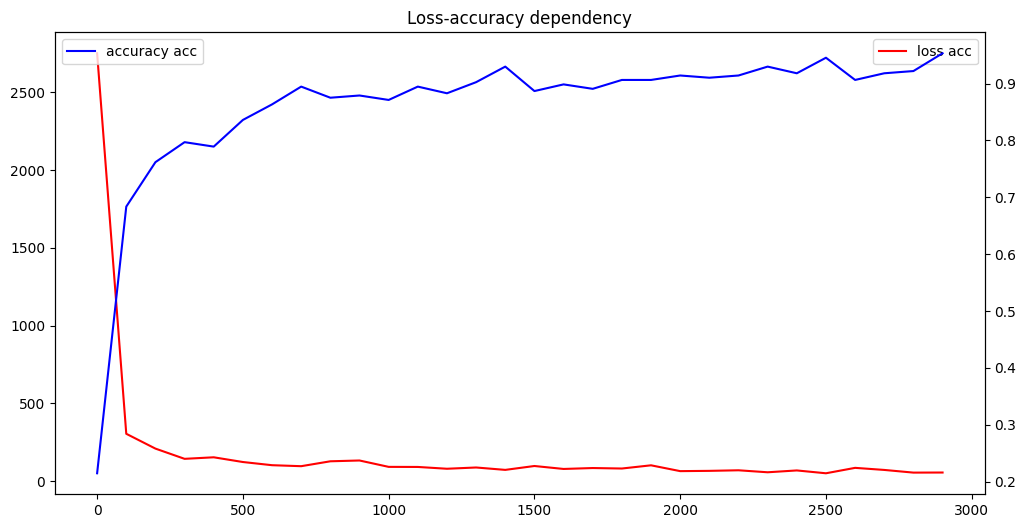

In [38]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
import pandas as pd
# Место для вашего кода
steps = pd.RangeIndex(0,training_steps, display_step)
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(steps, loss_history, 'r', label='loss acc')
ax.legend()
ax2=ax.twinx()
ax2.plot(steps, accuracy_history, 'b', label='accuracy acc')
plt.title('Loss-accuracy dependency')
plt.legend()
plt.show()

In [39]:
# Вычислите точность обученной нейросети

# Место для вашего кода
net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy is {net_accuracy}")

Accuracy is 0.9226499795913696


True: 1 Predict: 1 True
True: 8 Predict: 8 True
True: 3 Predict: 3 True
True: 2 Predict: 2 True
True: 9 Predict: 9 True
True: 6 Predict: 5 False
True: 7 Predict: 7 True
True: 0 Predict: 0 True
True: 4 Predict: 4 True
True: 6 Predict: 6 True


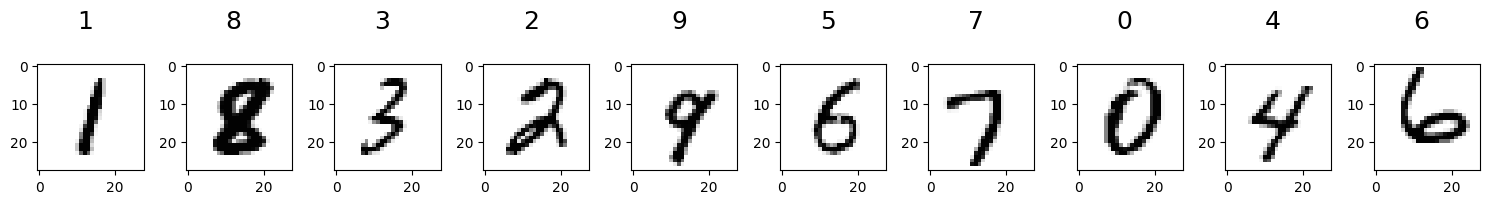

In [49]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Место для вашего кода
# np.random.seed(42)
test_pics = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_pics]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_pics])]

plt.figure(figsize=(15, 5))
for x in range(10):
    print(f"True: {y_test_true[x]} Predict: {pred_data[x]} {True if y_test_true[x]-pred_data[x]==0 else False}")
    plt.subplot(1, 10, (x + 1))
    plt.imshow(x_test[test_pics[x]].reshape(28, 28), cmap=plt.cm.Greys)
    plt.text(x=10, y=-10, s=pred_data[x], fontsize=18)
    
plt.tight_layout()
plt.show()


### Answer

10 picture sample is quite a small for drawing conclusions. On average we have 10 % false answers. 
Most numbers are falsly recognized as no 5 even though the result is obviously not 5 but 8, 6 or 3. 
Also the reason for bad recognition can often be a very bad handwriting when even a persons brain strugles to say, what number it is. 